<img src="../images/ObjectDetection/4-2.jpg">

> Ren S, He K, Girshick R, et al. Faster r-cnn: Towards real-time object detection with region proposal networks[J]. Advances in neural information processing systems, 2015, 28.

# 论文概述

`Faster R-CNN`是作者Ross Girshick：继`Fast R-CNN`后的又一力作。同样使用`VGG16`作为网络的backbone，推理速度在GPU上达到5fps(包括候选区域的生成)，准确率也有进一步的提升。在2015年的LSVRC以及COCO竞赛中获得多个项目的第一名。

该网络的主要贡献在于：
- 性能优越：`Faster RCNN`通过两阶网络与`RPN`，实现了精度较高的物体检测性能。
- 两阶网络：相比起其他一阶网络，两阶更为精准，尤其是针对高精度、多尺度以及小物体问题上，两阶网络优势更为明显。
- 通用性与鲁棒性：`Faster RCNN`在多个数据集及物体任务上效果都很好，对于个人的数据集，往往Fine-tune（微调）后就能达到较好的效果。
- 可优化点很多：`Faster RCNN`的整个算法框架中可以进行优化的点很多，提供了广阔的算法优化空间。
- 代码全面：各大深度学习框架都有较好的`Faster RCNN`源码实现，使用方便。

<img src="../images/ObjectDetection/4-4.jpg" width=400>


## 算法步骤

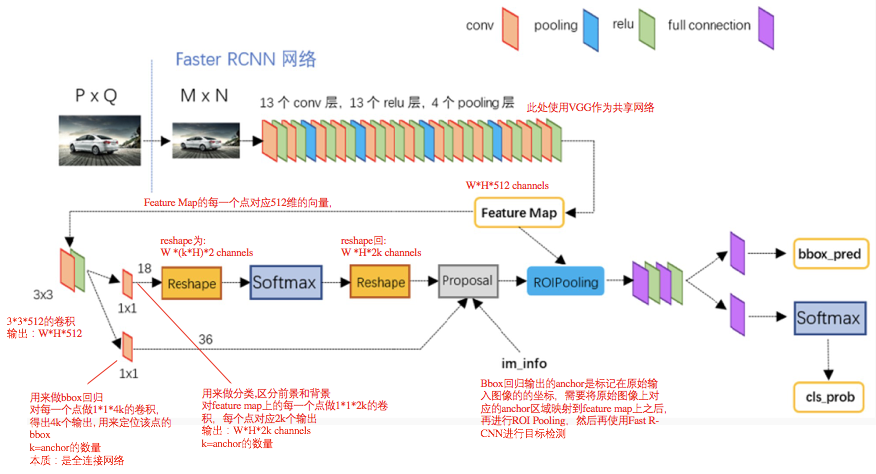

###  Conv layers

<span class="mark">Conv layers</span>:**将图像输入网络得到相应的特征图**
> `Fast R-CNN`虽然提出了`ROI Pooling`的特征提取方式，很好地解决了传统`R-CNN`中将候选区域分别输入CNN网络中的弊端。但都是使用传统`Selective Search`搜索方式确定候选区域，训练和测试时消耗了大量时间在RP搜索上。

   论文中使用`VGG`/`ZFNet`作为基础网络。上图是基于`VGG16`进行绘制的.以`VGG16`为例:
    全卷积网络使用VGG16作为骨架网络, 共有13个conv层，13个relu层，4个pooling层。
   - 所有的conv层都是：`kernel_size=3，pad=1，stride=1`
        
   所有的卷积都做了扩边处理（ pad=1，即填充一圈0），导致原图变为 $(M+2)×(N+2)$大小，再做3x3卷积后输出$M×N$ 。正是这种设置，导致*Conv layers*中的conv层不改变输入和输出矩阵大小
<img src="../images/ObjectDetection/4-6.jpg" width=400>
     
   - 所有的pooling层都是：`kernel_size=2，pad=0，stride=2`
    
    每个经过pooling层的$M×N$矩阵，都会变为$(M/2)×(N/2)$大小。综上所述，在整个*Conv layers*中，conv和relu层不改变输入输出大小，只有pooling层使输出长宽都变为输入的1/2。
    

   经过卷积模块得到相应的特征图后，一个$M×N$（800×600）大小的输入图像就变为了$\left(\frac{M}{16}\right)×\left(\frac{N}{16}\right)$的特征图(由于包含了4个池化层,即$(\frac{1}{2})^4$).
    

### Region Proposal Networks

 <span class="mark">Region Proposal Networks</span>:**使用RPN结构生成候选框，将RPN生成的候选框投影到特征图上获得相应的特征矩阵**
> `Faster R-CNN`在`Fast R-CNN`的基础上，提出了`RPN`网络用来生成候选区域。通过网络共享将提取候选框与目标检测结合成一个整体进行训练，替换了`Fast R-CNN`中使用`Selective Search`进行提取候选框的方法，提高了测试过程的速度。
> <img src="../images/ObjectDetection/4-7.jpg" width=600> 以看到`RPN`网络实际分为2条线:
>    - 上面一条通过`softmax`分类anchors获得正负分类
>    - 下面一条用于计算对于anchors的bounding box regression偏移量，以获得精确的proposal。
>    - 最后的Proposal层则负责综合positive anchors和对应bounding box regression偏移量获取proposals，同时剔除太小和超出边界的proposals。其实整个网络到了Proposal Layer这里，就完成了相当于目标定位的功能。
>    - **总结: 生成anchors -> softmax分类器提取positvie anchors -> bbox reg回归positive anchors -> Proposal Layer生成proposals**

#### 生成anchors

> anchor的概念：其思想就是**将特征图上的每一个点映射回原始输入图像上**，在原始图像上以该点为中心生成不同尺寸、不同比例的候选框，作为RPN待分类的候选框.设为每个特征点生成$k$个anchor，若Feature Map大小为$W×H$，则该特征图共有$W×H×k$个anchor。

- `cls layer`：每一个特征点包括$k$个anchor，使用**2位来标记每个anchor是否包含目标的概率**。

- `reg layer`：每一个特征点对应$k$个anchor，使用**4位来表示每个anchor的bounding box**，`reg layer`对bounding box进行回归修正其边界。

- 对于特征图上的每个3x3的滑动窗口，计算出滑动窗口中心点对应原始图像上的中心点，获得一个512维度的向量,并计算出k个 anchor boxes(注意和proposal的差异)。
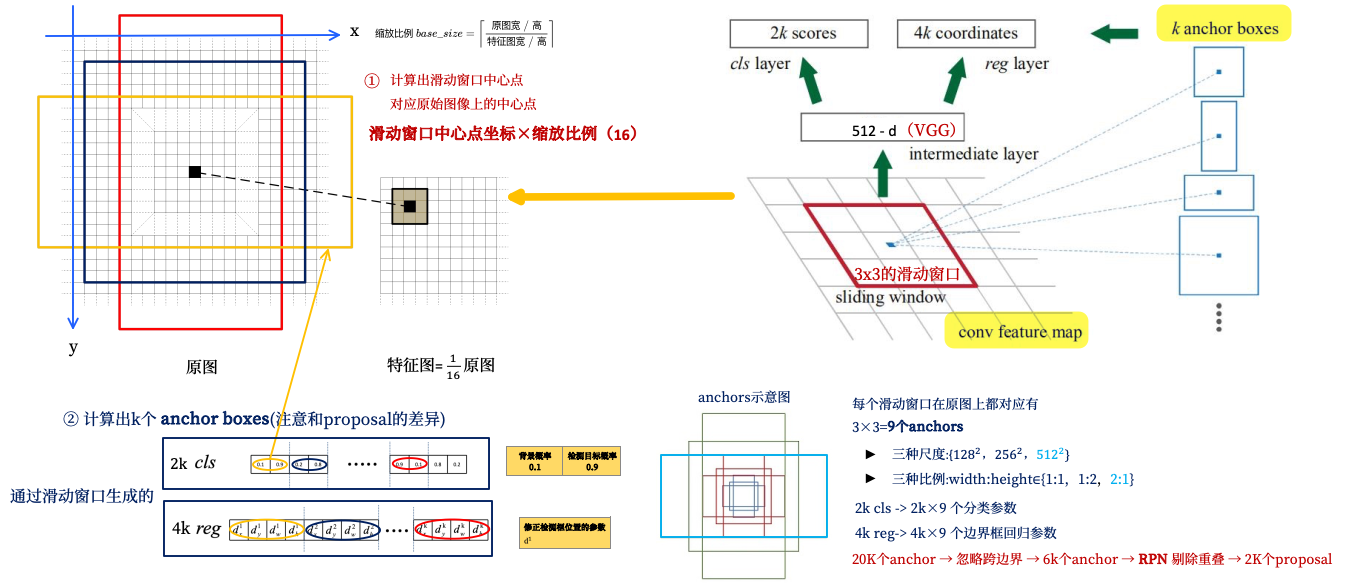    
> 感受野计算公式：$F (i) = [ F (i + 1) - 1] × Stride + Ksize$
>
> 对于ZF感受野：171 ; 对于VGG感受野：228. 
>
> 为什么可以预测比自己感受野尺度大的边界框?作者认为根据经验是可以实现的.


Q：使用anchor的好处是什么？

A：虽然也是使用滑动窗口思想，但是滑动窗口操作是在卷积层特征图上进行的，维度较原始图像降低了16x16倍（中间经过了4次2x2的pooling操作）；另外采用了9种anchor可以获得多尺度特征，对应了三种尺度和三种长宽比，加上后边接了边框回归，所以即便只使用这9种anchor外的窗口也能得到一个跟目标比较接近的region proposal。

- 对于一张1000x600x3的图像，**大约有60x40x9(20k)个anchor**，忽略跨越边界的anchor以后，剩下约6k个anchor。对于`RPN`生成的候选框之间存在大量重叠，基于候选框的cls得分，采用非极大值抑制，**IoU设为0.7**，这样**每张图片只剩2k个候选框proposal**。
- 全部anchors拿去训练太多了，训练程序会在合适的anchors中随机选取128个postive anchors+128个negative anchors进行训练
  - postive判定:（i）一个与GT的IoU大于0.7的候选框 或（ii）anchors与某个GT具有最高IoU(当没有一个候选框与GT的IoU大于0.7时)
  - negative判定:与所以GT的IoU都小于0.3的候选框
  - 对于非postive/negative的样本全部舍弃;跨越图像边界的anchor全部舍弃。

#### softmax判定positive与negative

一副$M×N$大小的矩阵送入`Faster RCNN`网络后，到`RPN`网络变为$(M/16)×(N/16)$，不妨设 $W=M/16$，$H=N/16$。

- `RPN网络`的上一条线是**通过`softmax`分类anchors获得正负样本(用来做分类，区分前景和背景**)
- 在进入reshape与softmax之前，对特征图上的每一个点做**1×1×2K的卷积**，每个点对应2K个输出(positive和negative), 因此经过该卷积的输出图像为$W×H×(9×2)$大小.
- 后面接softmax分类获得positive anchors，也就相当于初步提取了检测目标候选区域box.

> 在softmax前后都接一个reshape layer,是因为caffe实现时存储形式:其在caffe blob中的存储形式为`[1, 2x9, H, W]`。而在softmax分类时需要进行positive/negative二分类，所以reshape layer会将其变为`[1, 2, 9xH, W]`大小，即单独“腾空”出来一个维度以便softmax分类，之后再reshape回复原状.

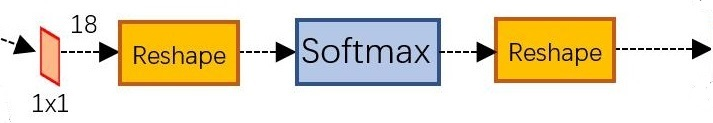

#### 对proposals进行bounding box regression

- `RPN网络`的下一条线**用于计算对于anchors的bounding box regression偏移量，以获得精确的proposal**
- 首先是对特征图上的每一个点做**1×1×4K的卷积**，每个点对应4K个输出(坐标回归参数), 因此经过该卷积的输出图像为$W×H×(9×4)$大小.

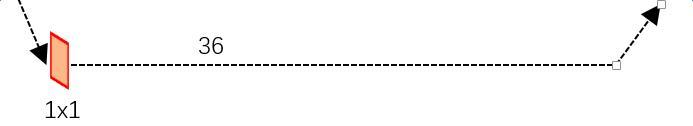

#### Proposal Layer

- `Proposal Layer`负责综合所有 $\left[d_x(A), d_y(A), d_w(A), d_h(A)\right]$ 变换量和positive anchors, 计算出精准的proposal, 送入后续`Rol Pooling Layer`。
- 输入: 分类器结果; 回归器偏移量; `im_info`.
- `im_info`:对于一副任意大小$P×Q$图像，**传入`Faster RCNN`前首先reshape**到固定$MxN$，`im_info=[M, N, scale_factor]`则保存了此次缩放的所有信息。然后经过`Conv Layers`，经过4次pooling变为$W×H=(M/16)×(N/16)$大小，其中feature_stride=16则保存了该信息，用于计算anchor偏移量。

<img src="../images/ObjectDetection/4-7.jpg" width=600> 

`Proposal Layer forward`按照以下顺序依次处理：

1. **生成anchors**，利用对$\left[d_x(A), d_y(A), d_w(A), d_h(A)\right]$所有的anchors做bbox regression**回归**（这里的anchors生成和训练时完全一致）
2. 按照输入的positive softmax scores由大到小**排序anchors**，**提取**前pre_nms_topN(e.g. 6000)个anchors，即提取修正位置后的positive anchors
3. 限定超出图像边界的positive anchors为图像边界，防止后续roi pooling时proposal超出图像边界
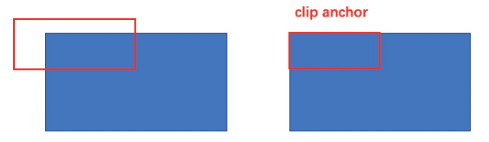
4. 剔除尺寸非常小的positive anchors
5. 对剩余的positive anchors进行NMS（nonmaximum suppression）
6. Proposal Layer有3个输入：positive和negative anchors分类器结果; im_info; 对应的bbox reg的结果.

输出proposal=$[x1, y1, x2, y2]$，注意，由于在第三步中将anchors映射回原图判断是否超出边界，所以这里输出的proposal是对应$M×N$输入图像尺度的，这点在后续网络中有用。另外我认为，严格意义上的检测应该到此就结束了，后续部分应该属于识别了。

### RoI pooling

<span class="mark">RoI pooling</span>:**将每个特征矩阵通过ROI pooling层缩放到7x7大小的特征图， 接着将特征图展平通过一系列全连接层得到预测结果**

RoI Pooling层则负责收集proposal，并计算出proposal feature maps，送入后续网络。Rol pooling层有2个输入：
- 原始的feature maps
- `RPN`输出的proposal boxes（大小各不相同）

`RoI Pooling layer forward`按照以下顺序依次处理：
1. 由于proposal是对应MxN尺度的，所以首先使用spatial_scale参数将其映射回(M/16)x(N/16)大小的feature map尺度；
2. 再将每个proposal对应的feature map区域水平分为 pooled_w x pooled_h 的网格；
3. 对网格的每一份都进行max pooling处理。

这样处理后，即使大小不同的proposal输出结果都是 pooled_w x pooled_h 固定大小，实现了固定长度输出。

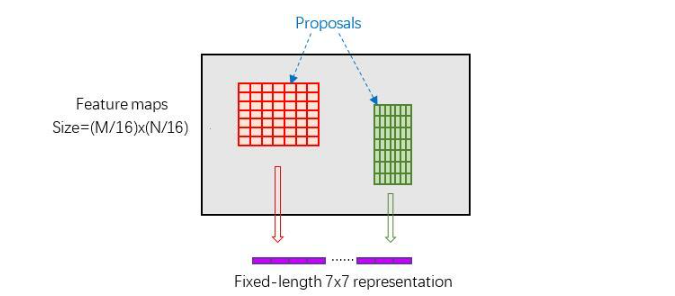

### Classification

`Classification`部分利用已经获得的proposal feature maps.
- 通过全连接层与`softmax`计算每个proposal具体属于那个类别（如人，车，电视等），输出cls_prob概率向量；
- 同时再次利用`bounding box regression`获得每个proposal的位置偏移量bbox_pred，用于回归更加精确的目标检测框。

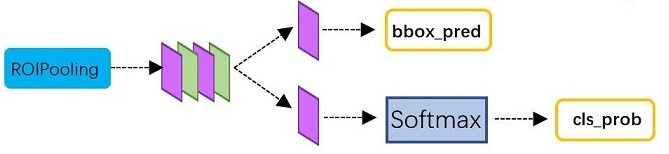

## RPN 多任务损失

> **RPN Multi-task loss**
> $$
\begin{array}{r}
L\left(\left\{p_i\right\},\left\{t_i\right\}\right)=\frac{1}{N_{c l s}} \color{red}{\sum L_{c l s}\left(p_i, p_i^*\right)} + \lambda \frac{1}{N_{\text {rea }}} \color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }.
\end{array}
$$
> 
>
>
> - $p_i$ 是表示第i个anchor预测为真实标签的概率
> - $p_i^*$ 当为正样本时为1，当为负样本时为0
> - $t_i$ 表示预测第i个anchorl的边界框回归参数
> - $t_i^*$ 表示第i个anchor)对应的GT Box的边界框回归参数
> - $N_{vls}$ 表示一个mini-batch中的所有样本数量256
> - $N_{reg}$ 表示anchor位置的个数（不是anchor个数）约2400

1. 分类损失:使用`Binary Cross Entropy Loss二值交叉熵损失`: 注意使用二值交叉熵损失这里是`cls layer` 只预测**k scores**,而不是2k scores.
$$\color{red}{\sum L_{c l s}\left(p_i, p_i^*\right)}\\
L_{c l s}=-\left[p_i^* \log \left(p_i\right)+\left(1-p_i^*\right) \log \left(1-p_i\right)\right]
$$

    - $p_i$表示第$i$个anchor预测为目标的概率 
    - $p_i^*$当为正样本时为1，当为负样本时为0
    
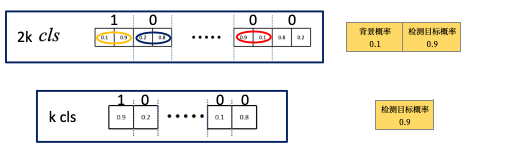

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
$$\color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }$$

\begin{aligned}
&L_{\text {loc }}\left(t_i, t_i^*\right)=\sum_{i} \operatorname{smooth}_{L_1}\left(t_i-t_i^*\right) \\
&t_i=\left[t_x, t_y, t_w, t_h\right] \quad t_i^*=\left[t_x^*, t_y^*, t_w^*, t_h^*\right] \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}

$$
\begin{aligned}
&t_x=\left(x-x_a\right) / w_a, t_y=\left(y-y_a\right) / h_a, \\
&t_w=\log \left(w / w_a\right), t_h=\log \left(h / h_a\right) \\
&t_x^*=\left(x^*-x_a\right) / w_a, t_y^*=\left(y^*-y_a\right) / h_a, \\
&t_w^*=\log \left(w^* / w_a\right), t_h^*=\log \left(h^* / h_a\right)
\end{aligned}
$$

## Fast R-CNN 多任务损失

> **Multi-task loss**
> 
> $$
L\left(p, u, t^u, v\right)=L_{c l s}(p, u)+\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)
$$
> 
>
>
> - $p$ 是分类器预测的 softmax概率分布 $p=\left(p_0, \ldots, p_k\right)$
> - $u$ 对应目标真实类别标签
> - $t^u$ 对应边界框回归器预测的对应类别
> - $u$ 的回归参数 $\left(t_x^u, t_y^u, t_w^u, t_h^u\right)$
> - $v$ 对应真实目标的边界框回归参数 $\left(v_x, v_y, v_w, v_h\right)$
> > $$
\begin{aligned}
&v_x=\left(G_x-P_x\right) / P_w \\
&v_y=\left(G_y-P_y\right) / P_h \\
&v_w=\log \left(G_w / P_w\right)  \\
&v_h=\log \left(G_h / P_h\right)
\end{aligned}
$$

1. 分类损失:使用`Cross Entropy Loss交叉熵损失`
$$L_{c l s}(p, u)=-logp_u$$

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
$$\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)$$

\begin{aligned}
&L_{\text {loc }}\left(t^u, v\right)=\sum_{i \in\{x, y, w, h\}} \operatorname{smooth}_{L_1}\left(t_i^u-v_i\right) \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}

## Faster R-CNN训练

- **直接采用RPN Loss+ Fast R-CNN Loss的联合训练方法**


- 原论文中采用分别训练`RPN`以及`Fast R-CNN`的方法
    1. 利用ImageNet预训练分类模型初始化前置卷积网络层参数，并开始单独训练RPN网络参数--对应stage1_rpn_train.pt；
    2. 固定`RPN`网络独有的卷积层以及全连接层参数，再利用 ImageNet预训练分类模型初始化前置卷积网络参数--对应rpn_test.pt
    3. 利用`RPN` 网络生成的目标建议框去训练`Fast RCNN`网络参数--stage1_fast_rcnn_train.pt
    4. 固定利用`Fast RCNN`训练好的前置卷积网络层参数，去微调`RPN` 网络独有的卷积层以及全连接层参数--stage2_rpn_train.pt
    5. 再次利用步骤4中训练好的`RPN`网络，收集proposals--对应rpn_test.pt
    6. 同样保持固定前置卷积网络层参数，去微调`Fast RCNN`网络的全连接层参数--stage2_fast_rcnn_train.pt
    7. 最后`RPN`网络与`Fast RCNN`网络共享前置卷积网络层参数，构成一个统一网络


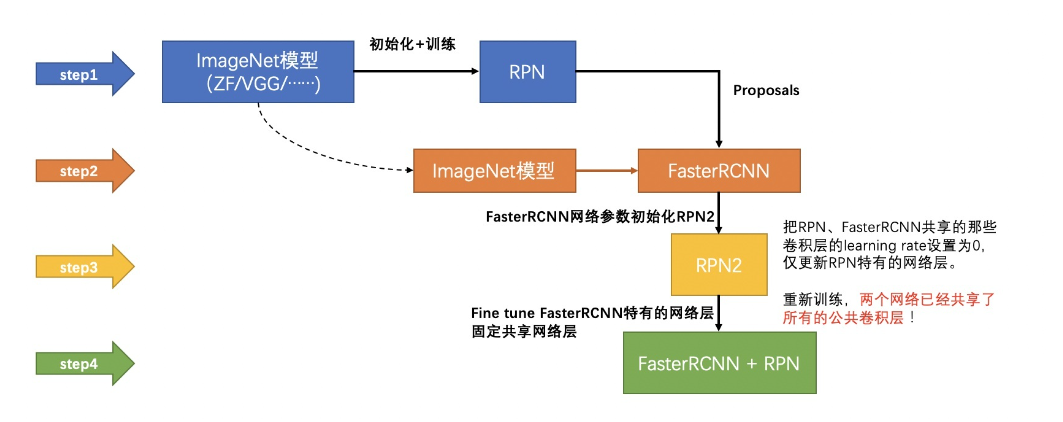

## 算法评价

当然，原始的Faster RCNN也存在一些缺点，而这些缺点也恰好成为了后续学者优化改进的方向，总体来看，可以从以下6个方面考虑：

1. 卷积提取网络：无论是`VGGNet`还是`ResNet`，其特征图仅仅是单层的，分辨率通常也较小，这些都不利于小物体及多尺度的物体检测，因此多层融合的特征图、增大特征图的分辨率等都是可以优化的方向。

2.  NMS：在`RPN`产生Proposal时为了避免重叠的框，使用了NMS，并以分类得分为筛选标准。但NMS本身的过滤对于遮挡物体不是特别友好，本身属于两个物体的Proposal有可能因为NMS而过滤为1个，造成漏检，因此改进优化NMS是可以带来检测性能提升的。

3. RoI Pooling：Faster RCNN的原始RoI Pooling两次取整带来了精度的损失，因此后续`Mask R-CNN`针对此Pooling进行了改进，提升了定位的精度。
4. 全连接：原始`Faster RCNN`最后使用全连接网络，这部分全连接网络占据了网络的大部分参数，并且RoI Pooling后每一个RoI都要经过一遍全连接网络，没有共享计算，而如今全卷积网络是一个发展趋势，如何取代这部分全连接网络，实现更轻量的网络是需要研究的方向。
5. 正负样本：在`RPN`及`R-CNN`部分，都是通过超参数来限制正、负样本的数量，以保证正、负样本的均衡。而对于不同任务与数据，这种正、负样本均衡方法是否都是最有效的，也是一个研究的方向。
6. 两阶网络：`Faster R-CNN`的`RPN`与`R-CNN`两个阶段分工明确，带来了精度的提升，但速度相对较慢，实际实现上还没有达到实时。因此，网络阶数也是一个值得探讨的问题，如单阶是否可以使网络的速度更快，更多阶的网络是否可以进一步提升网络的精度等。

### 对于Faster RCNN的改进算法

- 特征融合：`HyperNet`

    对于`Faster R-CNN`第一个缺点，`HyperNet`提出了一种阶段方法。他认为单独的一个feature map无法覆盖所有的RoI的全部特性，因此**提出了一个融合浅、中、深三个层次的特征**，取长补短，去处理好区域生成的同时，实现更好的检测效果。
    
    `HyperNet`结构图如下，主要是四个过程，首先将图片输入到网络，然后计算超特征（Hyper Feature）表达，然后产生100个Proposal，最后对每个区域进行分类的调整: `HyperNet`以`VGG`为基础网络，分别从第1、3、5个卷积组后提取特征，分别对应浅层、中层和深层的信息。然后**对浅层特征进行最大值池化**，**对深层特征进行反卷积实现上采样**，使得二者的分辨率都是原图的1/4，与中层分辨率相同，方便最终融合。最终将三个特征图送入一个5×5的卷积来减少特征通道（减少到42）.在多尺度的特征图进行concatenate的时候，作者使用了LRN进行归一化.|

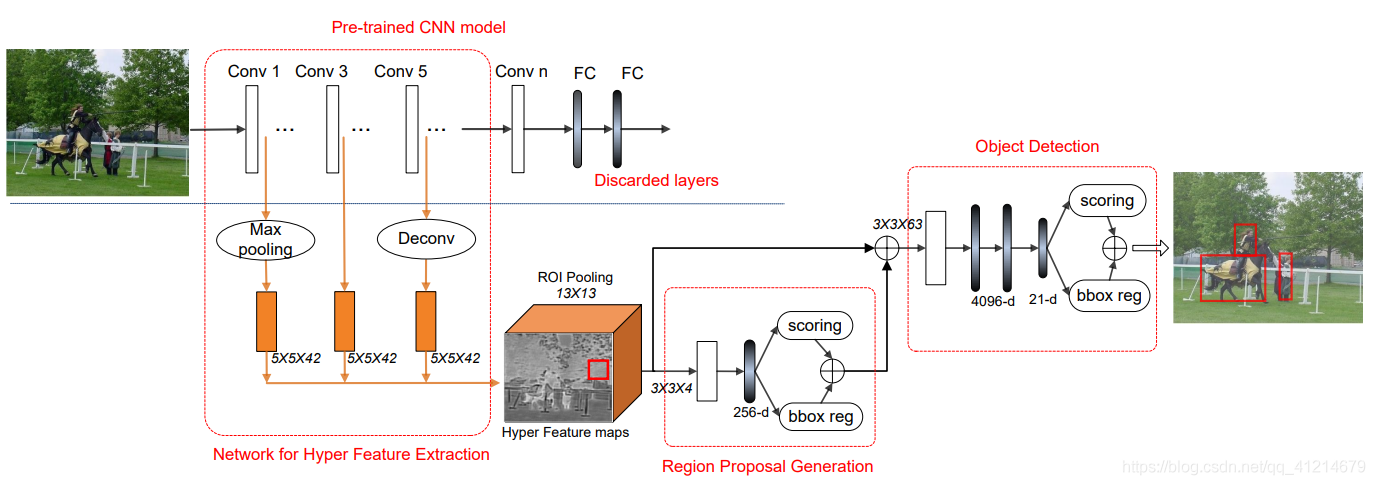

- 实例分割：`Mask R-CNN`
    相较于Faster RCNN，虽然类似，但主要有三个区别：
    1. 基础网络选择更加优秀的`ResNet-FPN`结构，生成更加有利于多尺度和小目标检测的多层特征图。
    2. 提出了`RoI Align`来代替`RoI Pooling`，解决`RoI Pooling`取整丢失信息从而损失精度问题，且这个问题对分割较为致命。
    3. 得到RoI区域特征后，在原本分类和回归基础上加入一个`FCN`构建的Mask分支用来实现像素级别的预测。

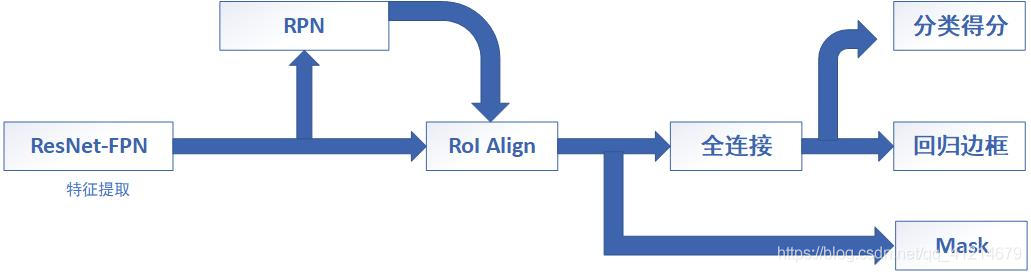

- 全卷积网络：`R-FCN`

    利用精心设计的一个`位置敏感的得分图positiom-sensitive score maps`实现对位置信息的感知，采用全卷积网络，大大减少网络的参数量。

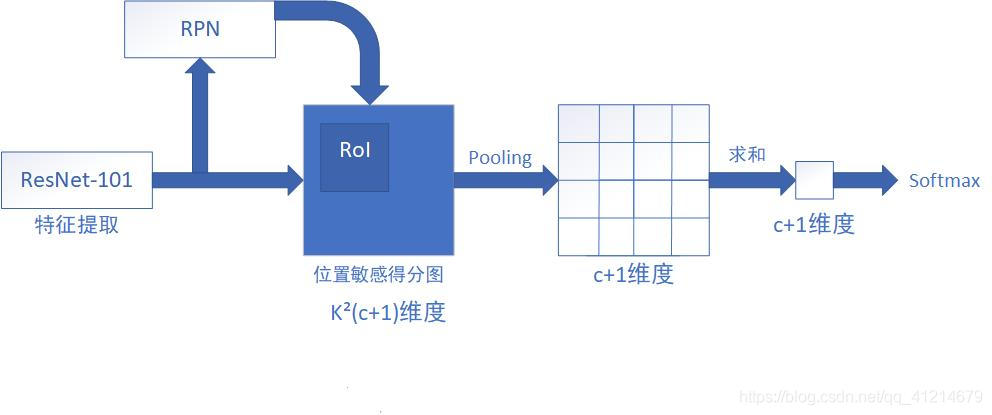

- 级联网络：`Cascade RCNN`

    `Faster RCNN`中会通过IoU来判断一个RoI是正样本还是负样本，默认阈值为0.5。

    事实上阈值的选择是一个矛盾的问题，阈值设置的很高的时候，RoI会接近实体，检测器定位更准确，但是用于训练的符合条件的RoI会变少，正样本更加少，样本分布更加不均衡；相反阈值很低的时候，正样本很多，有利于训练，单户增加误检，增加误差。
    
    基于此，`Cascade RCNN`算法深度探讨了IoU阈值对于检测器性能的影响，通过级联多个检测器来优化结果，每个检测器都基于不同的IoU阈值来界定正负样本，前一个检测器的输出作为后一个检测器的输入，检测器越靠后，IoU阈值越高。

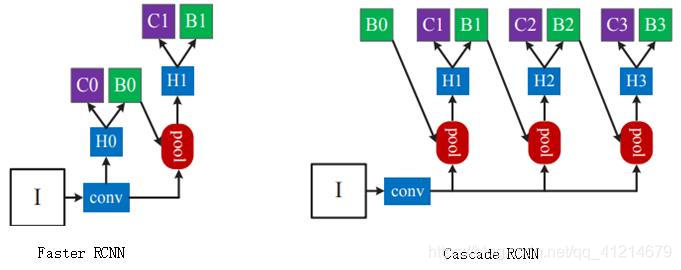

# 论文精读

## 摘要

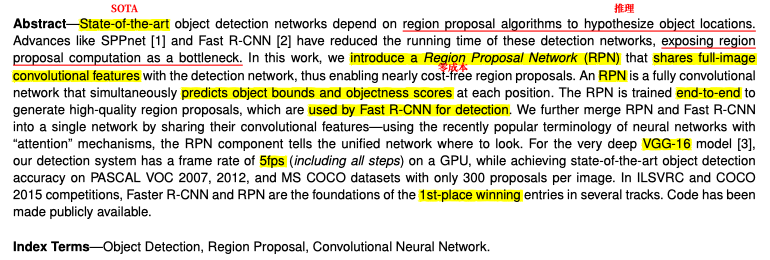

## 引言

目标检测的最新进展是由`region proposal`方法和基于区域的卷积神经网络（R-CNN）的成功驱动的。**忽略花费在`region proposals`上的时间**，最新版本`Fast R-CNN`,利用非常深的网络实现了**接近实时**的速率。`Selective Search`是最流行的方法的获取候选区域的方法之一。然而，与有效的检测网络相比，`Selective Search`速度慢了一个数量级，在CPU实现中每张图像的时间为2秒.

加速`region proposal`计算的一个方法是将其在GPU上重新实现。但重新实现忽略了下游检测网络，因此错过了**共享计算**的重要机会。

在本文中,作者提出了**使用深度卷积神经网络计算region proposal**, 其中在给定检测网络计算的情况下`region proposal`计算接近零成本。为此，我们**引入了新的region proposal网络（RPN）**，它们共享最先进目标检测网络的卷积层。通过在测试时共享卷积，计算region proposal的边际成本很小（例如，**每张图像仅需10ms**）。

`RPN`是一种全卷积网络，可以针对生成检测区域proposals的任务进行端到端的训练;引入新的`anchor`框作为多种尺度和长宽比的参考.

为了将`RPN`与`Fast R-CNN`目标检测网络相结合，我们提出了一种训练方案，在**微调 region proposal任务和微调目标检测之间进行交替，同时保持region proposal的固定**

## FASTER R-CNN

`Faster R-CNN`，由两个模块组成。第一个模块是产生proposes regions的深度全卷积网络，第二个模块是使用proposes regions的`Fast R-CNN`检测器

<img src="../images/ObjectDetection/4-4.jpg" width=400>

### region proposal网络

`region proposal`网络（RPN）**以任意大小的图像作为输入**，**输出一组矩形的目标proposals**，每个proposals都有一个目标得分.注意,作者将`Conv layers`也归为RPN网络内.**作者研究了具有5个共享卷积层的`ZFNet`和具有13个共享卷积层的`VGG-16`,以得到相应的特征图**.

为了生成`region proposal`，我们在最后的共享卷积层输出的卷积特征图上滑动一个小网络。这个小网络将输入卷积特征图的$n×n$空间窗口作为输入。每个滑动窗口映射到一个低维特征（ZF为256维，VGG为512维，后面是ReLU）。这个特征被输入到两个子全连接层一个**边界框回归层（reg）**和一个**边界框分类层（cls）**。

在本文中，我们使用$n=3$，注意输入图像上的有效感受野（ZF和VGG分别为171和228个像素）。请注意，因为小网络以滑动窗口方式运行，所以所有空间位置共享全连接层。这种架构通过一个n×n卷积层、后面接两个子$1×1$卷积层（分别用于reg和cls）自然地实现了。

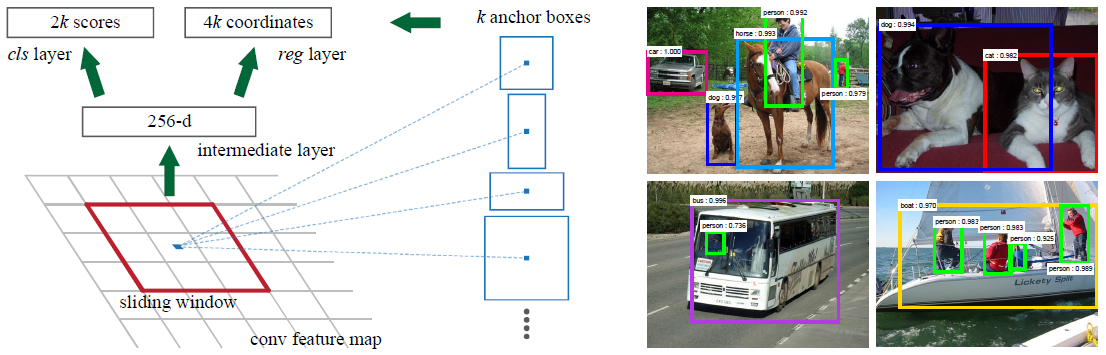

#### Anchors

anchor的概念：其思想就是**将特征图上的每一个点映射回原始输入图像上**，在原始图像上以该点为中心生成不同尺寸、不同比例的候选框，作为RPN待分类的候选框.设为每个特征点生成$k$个anchor，若Feature Map大小为$W×H$，则该特征图共有$W×H×k$个anchor。

在每个滑动窗口位置，我们同时预测多个`region proposal`，其中每个位置可能候选的最大数目表示为$k$。因此，reg层具有4k个输出，分别编码k个边界框的坐标，cls层输出2k个得分值，分别估计每个proposal是目标或不是目标的概率。

anchors位于所讨论的滑动窗口的中心，并且具有一定的尺度和长宽比。默认情况下，我们使用**3个尺度和3个长宽比**，在每个滑动位置产生**$k=9$个anchors**。对于大小为$W×H$（通常约为2400）的卷积特征图，总共有$WHk$个anchors。

- 平移不变的Anchors
        该方法的一个重要特性是它是平移不变的, 平移不变特性也减小了模型的大小.

- 多尺度Anchors作为回归参考

    Anchor的提出其实是为了引入多尺度的特征。

    常用的两种引入多尺度的方法有：

    - 基于image/feature pyramids ： 将图像resize成不同尺度大小，然后使用conv layers计算每一个尺度下的feature maps。虽然效果很好，但是却非常耗时。

    - 基于多尺度滑动窗口Sliding windows of multiple scales：在feature maps上使用不同尺度的滑动窗口。第二种方法通常与第一种方法结合使用。


    Anchor则是在单一尺度图像上计算卷积特征，并且通过与Fast R-CNN共享特征，而不需要引入其他的计算就可以得到多尺度特性。
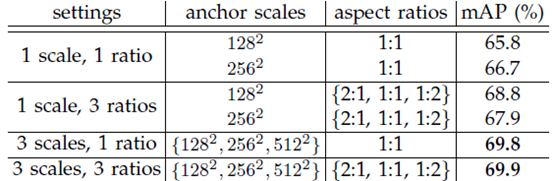

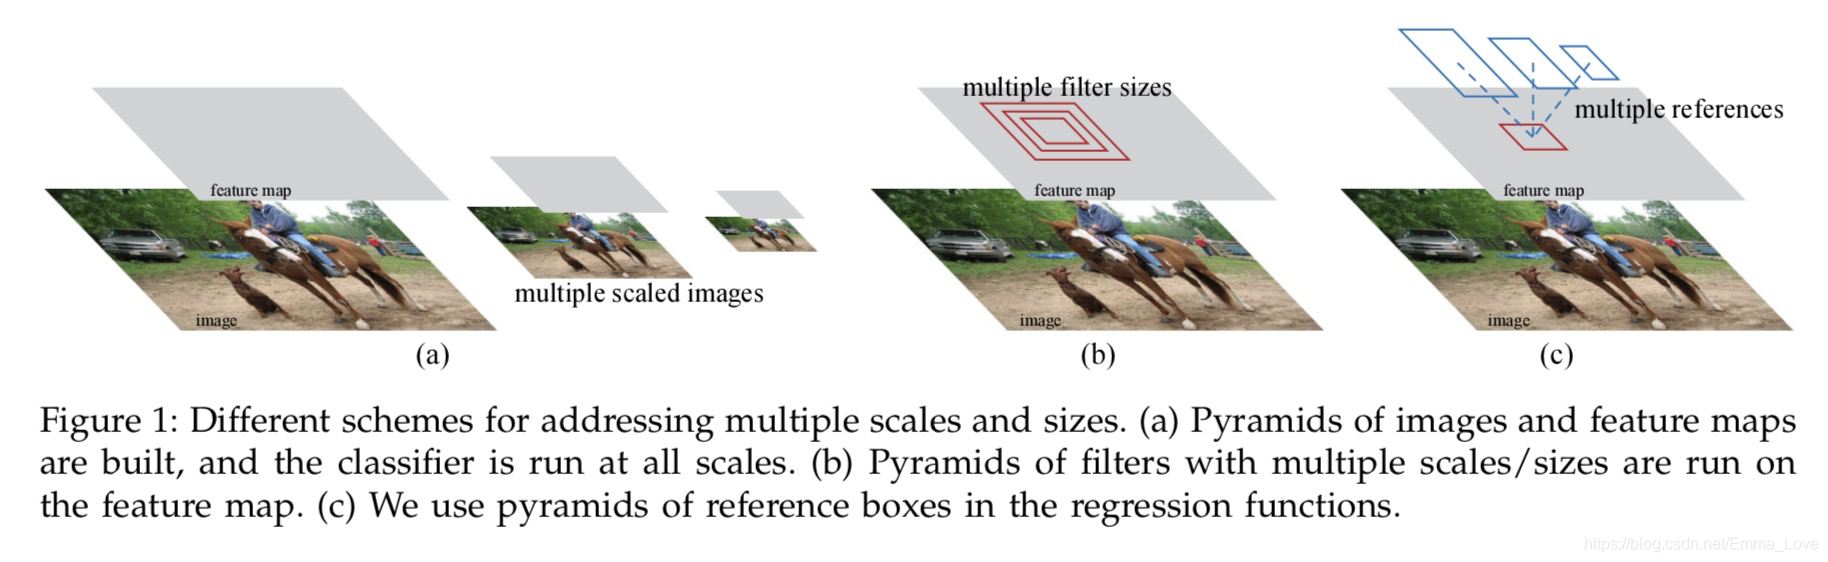

#### 损失函数

为了训练RPN，需要给每个anchor分配类别标签：{目标，非目标}。正负样本标记规则如下：

1. 目标

    满足下列条件之一的anchor就可以被标记为正样本：

    - 与任意ground-truth (GT) box的IoU重叠率最大的anchor（也许不到0.7）

    - 与任意ground-truth (GT) box的IoU重叠率大于0.7的anchor

    基本采用条件2就可以获得足够的正样本，但是对于一些极端情况，可以采用条件1生成正样本
    

2. 非目标

    与所有GT box的IoU都小于0.3的anchorb被标记为负样本

> **RPN Multi-task loss**
> $$
\begin{array}{r}
L\left(\left\{p_i\right\},\left\{t_i\right\}\right)=\frac{1}{N_{c l s}} \color{red}{\sum L_{c l s}\left(p_i, p_i^*\right)} + \lambda \frac{1}{N_{\text {rea }}} \color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }.
\end{array}
$$
> 
>
>
> - $p_i$ 是表示第i个anchor预测为真实标签的概率
> - $p_i^*$ 当为正样本时为1，当为负样本时为0
> - $t_i$ 表示预测第i个anchorl的边界框回归参数
> - $t_i^*$ 表示第i个anchor)对应的GT Box的边界框回归参数
> - $N_{vls}$ 表示一个mini-batch中的所有样本数量256
> - $N_{reg}$ 表示anchor位置的个数（不是anchor个数）约2400

1. 分类损失:使用`Binary Cross Entropy Loss二值交叉熵损失`: 注意使用二值交叉熵损失这里是`cls layer` 只预测**k scores**,而不是2k scores.
$$\color{red}{\sum L_{c l s}\left(p_i, p_i^*\right)}\\
L_{c l s}=-\left[p_i^* \log \left(p_i\right)+\left(1-p_i^*\right) \log \left(1-p_i\right)\right]
$$

    - $p_i$表示第$i$个anchor预测为目标的概率 
    - $p_i^*$当为正样本时为1，当为负样本时为0

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
$$\color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }$$

\begin{aligned}
&L_{\text {loc }}\left(t_i, t_i^*\right)=\sum_{i} \operatorname{smooth}_{L_1}\left(t_i-t_i^*\right) \\
&t_i=\left[t_x, t_y, t_w, t_h\right] \quad t_i^*=\left[t_x^*, t_y^*, t_w^*, t_h^*\right] \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}

$$
\begin{aligned}
&t_x=\left(x-x_a\right) / w_a, t_y=\left(y-y_a\right) / h_a, \\
&t_w=\log \left(w / w_a\right), t_h=\log \left(h / h_a\right) \\
&t_x^*=\left(x^*-x_a\right) / w_a, t_y^*=\left(y^*-y_a\right) / h_a, \\
&t_w^*=\log \left(w^* / w_a\right), t_h^*=\log \left(h^* / h_a\right)
\end{aligned}
$$

#### 训练RPN

> **RPN Multi-task loss**
> $$
\begin{array}{r}
L\left(\left\{p_i\right\},\left\{t_i\right\}\right)=\frac{1}{N_{c l s}} \color{red}{\sum L_i L_{c l s}\left(p_i, p_i^*\right)} + \lambda \frac{1}{N_{\text {rea }}} \color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }.
\end{array}
$$
> 
>
>
> - $p_i$ 是表示第i个anchor预测为真实标签的概率
> - $p_i^*$ 当为正样本时为1，当为负样本时为0
> - $t_i$ 表示预测第i个anchorl的边界框回归参数
> - $t_i^*$ 表示第i个anchor)对应的GT Box的边界框回归参数
> - $N_{vls}$ 表示一个mini-batch中的所有样本数量256
> - $N_{reg}$ 表示anchor位置的个数（不是anchor个数）约2400

1. 分类损失:使用`Binary Cross Entropy Loss二值交叉熵损失`: 注意使用二值交叉熵损失这里是`cls layer` 只预测**k scores**,而不是2k scores.
$$\color{red}{\sum L_i L_{c l s}\left(p_i, p_i^*\right)}\\
L_{c l s}=-\left[p_i^* \log \left(p_i\right)+\left(1-p_i^*\right) \log \left(1-p_i\right)\right]
$$

    - $p_i$表示第$i$个anchor预测为目标的概率 
    - $p_i^*$当为正样本时为1，当为负样本时为0

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
$$\color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }$$

\begin{aligned}
&L_{\text {loc }}\left(t_i, t_i^*\right)=\sum_{i} \operatorname{smooth}_{L_1}\left(t_i-t_i^*\right) \\
&t_i=\left[t_x, t_y, t_w, t_h\right] \quad t_i^*=\left[t_x^*, t_y^*, t_w^*, t_h^*\right] \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}

$$
\begin{aligned}
&t_x=\left(x-x_a\right) / w_a, t_y=\left(y-y_a\right) / h_a, \\
&t_w=\log \left(w / w_a\right), t_h=\log \left(h / h_a\right) \\
&t_x^*=\left(x^*-x_a\right) / w_a, t_y^*=\left(y^*-y_a\right) / h_a, \\
&t_w^*=\log \left(w^* / w_a\right), t_h^*=\log \left(h^* / h_a\right)
\end{aligned}
$$

`RPN`可以通过反向传播和随机梯度下降（SGD）进行端对端训练。我们遵循中的“图像中心”采样策略来训练这个网络。每个小批量数据都从包含许多正样本和负样本anchor的**单张图像**中产生。对所有anchor的损失函数进行优化是可能的，但是这样会偏向于负样本，因为它们是占大部分的。

取而代之的是，**我们在图像中随机采样256个anchor，计算一个小批量数据的损失函数**，其中采样的**正anchor和负anchor的比率可达1:1**。如果图像中的**正样本少于128个，我们使用负样本填充小批量数据**。

我们通过从标准方差为0.01的零均值高斯分布中获得权重来随机初始化所有新层。所有其他层（即共享卷积层）通过预训练的ImageNet分类模型来初始化，如同标准操作。我们fine-tune ZF网络的所有层，以及VGG网络的conv3_1及其之上的层以节省内存。对于60k的小批量数据，我们使用0.001的学习率，对于PASCAL VOC数据集中的下一个20k小批量数据，使用0.0001。我们使用0.9的动量和0.0005的重量衰减。

### RPN和Fast R-CNN共享特征

作者讨论三个方法来训练具有共享特征的网络：
1. **交替训练**。在这个解决方案中，我们首先训练`RPN`，并使用这些proposals来训练`Fast R-CNN`。由`Fast R-CNN` fine-tune的网络然后被用于初始化RPN，并且重复迭代这个过程。这是本文所有实验中使用的解决方案。
    - **四步交替训练**。在本文中，我们采用实用的四步训练算法，通过交替优化学习共享特征。
        1. 在第一步中，我们按照2.3.1节的描述训练RPN。该网络使用`ImageNet`的预训练模型进行初始化，并针对region proposal任务进行了端到端的fine-tune。
        2. 在第二步中，我们使用由第一步RPN生成的提议，由`Fast R-CNN`训练单独的检测网络。该检测网络也由ImageNet的预训练模型进行初始化。此时两个网络不共享卷积层。`
        3. 在第三步中，我们使用`Fast R-CNN`网络来初始化`RPN`训练，但是我们保持卷积层参数不变，并且只对`RPN`特有的层进行fine-tune。现在这两个网络共享卷积层。
        4. 最后，保持共享卷积层的固定，我们对`Fast R-CNN`的独有层进行fine-tune。因此，两个网络共享相同的卷积层并形成统一的网络。类似的交替训练可以运行更多的迭代，但是我们观察改进只有一点点，甚至可以忽略。
    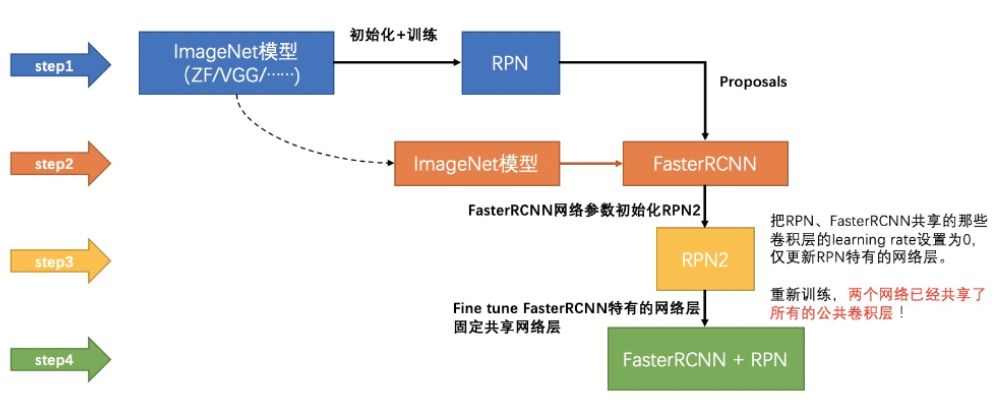

2. **近似联合训练**。在这个解决方案中，`RPN`和`Fast R-CNN`网络在训练期间合并成一个网络。在每次SGD迭代中，前向传递生成region proposal，在训练`Fast R-CNN`检测器将这看作是固定的、预计算的提议。反向传播像往常一样进行，其中对于共享层，组合来自RPN损失和Fast R-CNN损失的反向传播信号。这个解决方案很容易实现。但是这个解决方案**忽略了关于proposals边界框的坐标（也是网络响应）的导数**，因此是近似的。在我们的实验中，我们实验发现这个求解器**产生了相当的结果，与交替训练相比，训练时间减少了大约25-50%**。
3. 非近似的联合训练。如上所述，由`RPN`预测的边界框也是输入的函数。`Fast R-CNN`中的RoI池化层接受卷积特征以及预测的边界框作为输入，所以理论上有效的反向传播求解器也应该包括关于边界框坐标的梯度。在上述近似联合训练中，这些梯度被忽略。在一个非近似的联合训练解决方案中，我们需要一个关于**边界框坐标可微分的RoI池化层**。这是一个重要的问题，可以通过中提出的`RoI warping`层给出解决方案，这超出了本文的范围。

### 实现细节

- 我们在单尺度图像上训练和测试region proposal和目标检测网络。我们再次缩放图像，使得它们的短边是$s=600$像素。
- 对于anchor，我们使用了3个尺度，边界框面积分别为$128^2,256^2,512^2$个像素，以及1:1，1:2和2:1的长宽比。
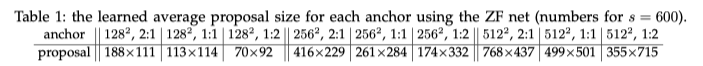
- 跨越图像边界的anchor框需要特殊处理。在训练过程中，我们忽略了所有的跨边界的anchor，所以不会造成损失。但在测试过程中，我们仍然将全卷积RPN应用于整张图像。可能会产生跨边界的proposal边界框,直接将其裁剪.
- 一些RPN proposals互相之间高度重叠。为了减少冗余，我们在proposals区域根据他们的cls分类得分采取非极大值抑制（NMS）。我们将NMS的IoU阈值固定为0.7，在NMS之后，我们使用前N个proposal regions来进行检测。

##  实验

### PASCAL VOC上的实验

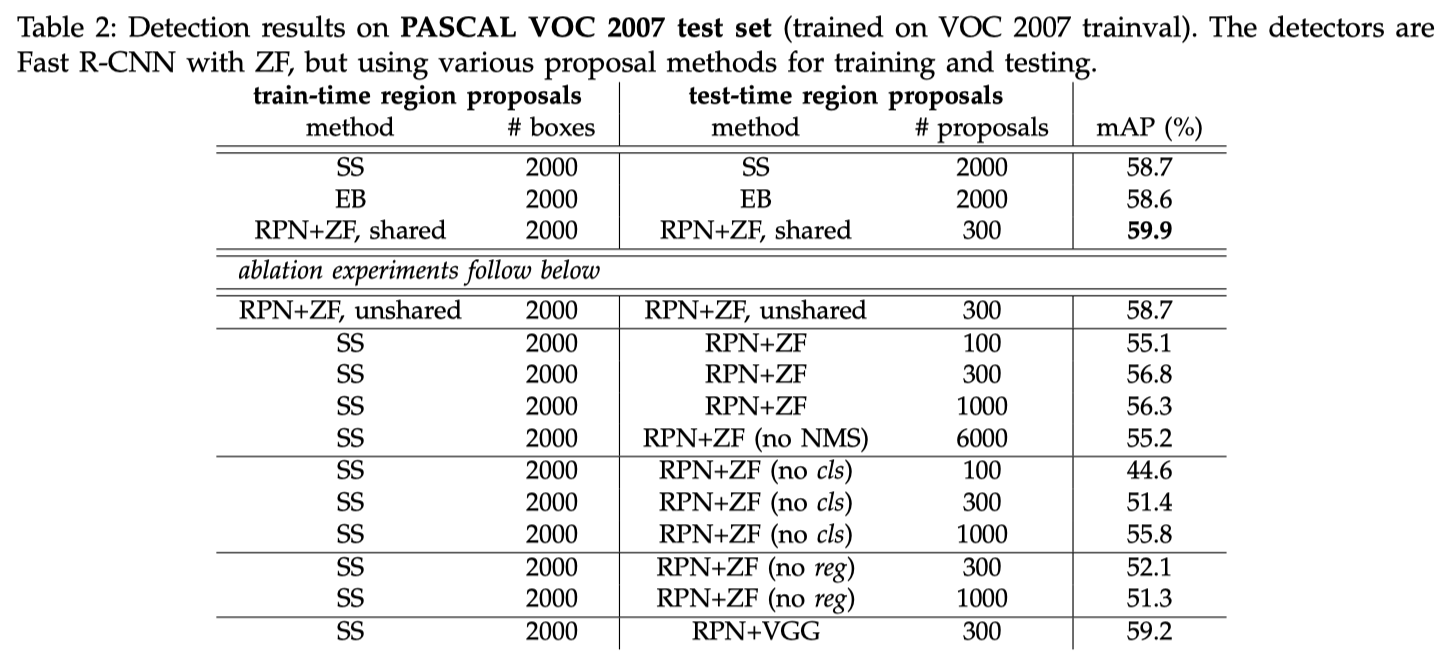

### 在MS COCO上的实验

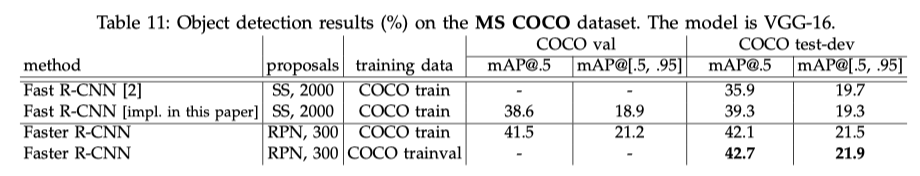

## 结论

我们已经提出了`RPN`来生成高效、准确的region proposal。通过与下游检测网络共享卷积特征，region proposal步骤几乎是零成本的。我们的方法使统一的、基于深度学习的目标检测系统能够以接近实时的帧率运行。学习到的`RPN`也提高了region proposal的质量，从而提高了整体的目标检测精度。

> create:Apotosome 11/21/22

> update:Apotosome 11/21/22